<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [24]:
import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround


import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99          # Discount factor (future reward importance)
alpha = 0.001         # Learning rate for optimizer
epsilon = 1.0         # Initial exploration rate
epsilon_min = 0.01    # Minimum exploration rate
epsilon_decay = 0.995 # Decay rate for epsilon per episode
num_episodes = 5000   # Total training episodes
batch_size = 64       # Mini-batch size for training
replay_buffer_size = 50000  # Max size of experience memory


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [25]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [26]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [27]:
# def epsilon_greedy(state, epsilon):
#   ############ TODO ###########
#   pass

def epsilon_greedy(state, epsilon):
    # Exploration
    if random.random() < epsilon:
        return env.action_space.sample()

    # Exploitation
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = q_net(state_tensor)
    return torch.argmax(q_values).item()

In [28]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [29]:
## Greedy evaluation helper function

import numpy as np
import torch

def evaluate_policy(q_net, env, device, n_eval_episodes=10):
    """
    Runs epsilon=0.0 (greedy) evaluation for n_eval_episodes.
    Returns:
      avg_steps_to_goal (lower is better),
      avg_return (less negative is better),
      reached_goal_ratio (for reference).
    """
    q_net.eval()
    steps_list = []
    returns_list = []
    reached = 0

    with torch.no_grad():
        for _ in range(n_eval_episodes):
            state = env.reset()[0]
            done = False
            ep_return = 0.0
            steps = 0

            while not done:
                s_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                q_vals = q_net(s_t)
                action = torch.argmax(q_vals, dim=1).item()

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                ep_return += reward
                steps += 1

            if terminated:  # reached the goal
                reached += 1

            steps_list.append(steps)
            returns_list.append(ep_return)

    q_net.train()
    avg_steps = float(np.mean(steps_list))
    avg_return = float(np.mean(returns_list))
    reached_goal_ratio = reached / n_eval_episodes
    return avg_steps, avg_return, reached_goal_ratio


In [30]:
## Storage for metrics
# Training-time tracking
rewards_dqn = []          # per-episode training return (already in your code)
eval_every = 100          # <-- run evaluation every N training episodes
eval_steps = []           # average steps-to-goal at each eval checkpoint
eval_returns = []         # average return at each eval checkpoint
eval_checkpoints = []     # episode indices when evaluation was run

In [31]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
    state = env.reset()[0]          # Gymnasium returns (obs, info)
    total_reward = 0
    done = False

    while not done:
        # 1. Choose action
        action = epsilon_greedy(state, epsilon)

        # 2. Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # 3. Store experience
        replay_buffer.append((state, action, reward, next_state, done))

        # 4. Train
        train_dqn()

        # 5. Update state and total reward
        state = next_state
        total_reward += reward

    # 6. Epsilon decay after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)

    # 7. Periodic evaluation (greedy, epsilon=0.0)
    if (episode + 1) % eval_every == 0:
        avg_steps, avg_ret, goal_ratio = evaluate_policy(q_net, env, device, n_eval_episodes=10)
        eval_steps.append(avg_steps)
        eval_returns.append(avg_ret)
        eval_checkpoints.append(episode + 1)
        print(f"[Eval @ ep {episode+1}] avg_steps={avg_steps:.1f}, "
              f"avg_return={avg_ret:.1f}, goal_rate={100*goal_ratio:.1f}%, "
              f"train_eps={epsilon:.3f}")


[Eval @ ep 100] avg_steps=200.0, avg_return=-200.0, goal_rate=0.0%, train_eps=0.606
[Eval @ ep 200] avg_steps=200.0, avg_return=-200.0, goal_rate=0.0%, train_eps=0.367
[Eval @ ep 300] avg_steps=200.0, avg_return=-200.0, goal_rate=0.0%, train_eps=0.222
[Eval @ ep 400] avg_steps=149.6, avg_return=-149.6, goal_rate=100.0%, train_eps=0.135
[Eval @ ep 500] avg_steps=189.4, avg_return=-189.4, goal_rate=80.0%, train_eps=0.082
[Eval @ ep 600] avg_steps=122.5, avg_return=-122.5, goal_rate=100.0%, train_eps=0.049
[Eval @ ep 700] avg_steps=134.0, avg_return=-134.0, goal_rate=100.0%, train_eps=0.030
[Eval @ ep 800] avg_steps=144.4, avg_return=-144.4, goal_rate=100.0%, train_eps=0.018
[Eval @ ep 900] avg_steps=200.0, avg_return=-200.0, goal_rate=0.0%, train_eps=0.011
[Eval @ ep 1000] avg_steps=149.7, avg_return=-149.7, goal_rate=70.0%, train_eps=0.010
[Eval @ ep 1100] avg_steps=134.2, avg_return=-134.2, goal_rate=100.0%, train_eps=0.010
[Eval @ ep 1200] avg_steps=135.3, avg_return=-135.3, goal_rate

In [32]:
print(rewards_dqn)

[-200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0,

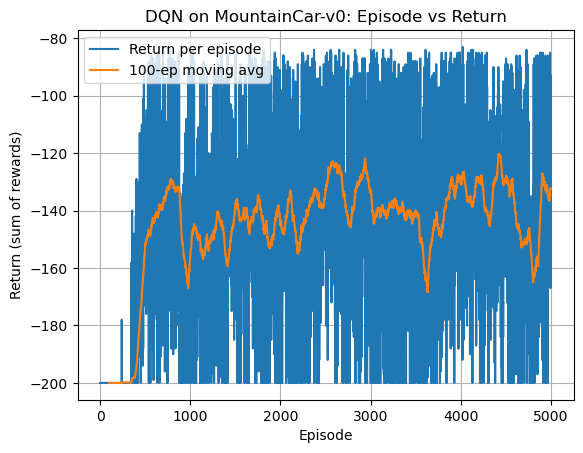

In [34]:
# --- Plot: Episode vs return ---
import numpy as np
import matplotlib.pyplot as plt

def plot_returns(returns, window=100, title="DQN on MountainCar-v0: Episode vs Return"):
    arr = np.asarray(returns, dtype=float)
    plt.figure()
    plt.plot(arr, label="Return per episode")
    if len(arr) >= window:
        mov = np.convolve(arr, np.ones(window)/window, mode="valid")
        plt.plot(range(window-1, window-1+len(mov)), mov, label=f"{window}-ep moving avg")
    plt.xlabel("Episode")
    plt.ylabel("Return (sum of rewards)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call after training:
plot_returns(rewards_dqn, window=100)


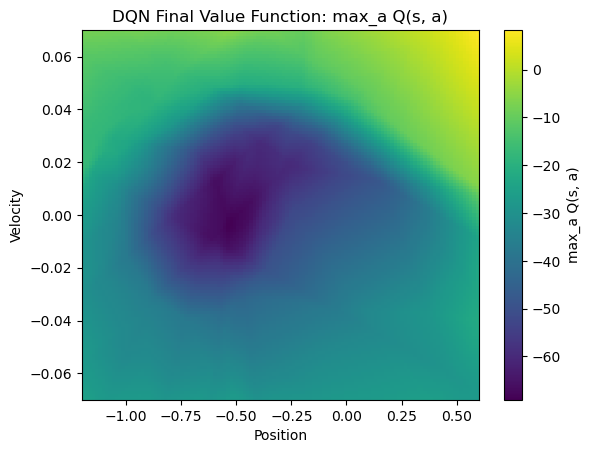

In [36]:
# --- Plot: Final value function max_a Q(s,a) over a 2D grid ---
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_value_function(q_net, env, device, pos_points=121, vel_points=121):
    pos_low, vel_low = env.observation_space.low
    pos_high, vel_high = env.observation_space.high

    pos_grid = np.linspace(pos_low, pos_high, pos_points)
    vel_grid = np.linspace(vel_low, vel_high, vel_points)

    V = np.zeros((vel_points, pos_points), dtype=np.float32)  # rows: velocity, cols: position
    q_net.eval()
    with torch.no_grad():
        for i_v, v in enumerate(vel_grid):
            states = np.stack([np.array([p, v], dtype=np.float32) for p in pos_grid], axis=0)
            states_t = torch.from_numpy(states).to(device)
            q_vals = q_net(states_t)                         # [pos_points, n_actions]
            V[i_v, :] = torch.max(q_vals, dim=1).values.cpu().numpy()
    q_net.train()

    plt.figure()
    extent = [pos_low, pos_high, vel_low, vel_high]
    im = plt.imshow(V, origin="lower", aspect="auto", extent=extent)
    plt.colorbar(im, label="max_a Q(s, a)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("DQN Final Value Function: max_a Q(s, a)")
    plt.show()

# Call after training:
plot_value_function(q_net, env, device)


**Short write-up**:
- How quickly does it learn? Does it reach the goal consistently?
  - It learns very slowly, the code was tried with 5000 episodes and took 21 minutes with CUDA Pytorch. However, it dousnt reach the goal consistently, as it can be seen in the graph, it shows a noise return, sometimes has a good return and other times a bad one. Overall, the return is maximazed comparing it to the inicial returns.
- **Comparison with tile coding**:
  - Which representation learns faster?
    - Of course tile coding learns faster since is discretizing the space.
  - Which one is more stable?
    - comparing to Tile coding exercise, looks like DQN is less stable, but could be due to the parameters and complexity of the algorithm rather than the capacity.
  - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
    - DQN is most likely to have better generalization because it is learning features, in the other hand, tiles can do it good but lacks of resolution, unless it is added more.
  - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
    - Yes, requires more tuning to ensure the convergence, with non linear models there is not an analitycal way to evaluate the convergence. Tile coding can run without lots of parameters.
- **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?
  - Tiles: Are much simplier, fast inicial learning, stable, However, it has lower resolution.
  - DQN: Has better potencial for generalization and flexibility. However, has more hyperparameters, and are slower.

---
---
---

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [21]:
# =========================
# DQN for LunarLander-v2
# =========================
# Requirements:
#   pip install gymnasium[box2d] torch numpy matplotlib

import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [22]:

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ---------- Environment ----------
env = gym.make("LunarLander-v3")
env.reset(seed=SEED)
n_actions = env.action_space.n          # 4
state_dim = env.observation_space.shape[0]  # 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [23]:

# ---------- Q-Network ----------
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)


In [24]:

# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done):
        self.buf.append((s, a, r, s2, done))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s2, d = zip(*batch)
        return (np.array(s, dtype=np.float32),
                np.array(a, dtype=np.int64),
                np.array(r, dtype=np.float32),
                np.array(s2, dtype=np.float32),
                np.array(d, dtype=np.float32))

    def __len__(self):
        return len(self.buf)


In [26]:

# ---------- Hyperparameters ----------
gamma = 0.99
lr = 1e-3
batch_size = 128
replay_capacity = 100_000
train_start = 10_000          # warmup transitions before learning
train_freq = 1                # learn every environment step
target_update_every = 1000    # hard update steps

epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 200_000  # linear decay over these steps

num_episodes = 3000
max_steps_per_ep = 1000


In [27]:

# ---------- Networks, Optimizer, Loss ----------
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=lr)
loss_fn = nn.SmoothL1Loss()  # Huber

replay = ReplayBuffer(replay_capacity)

# ---------- Epsilon schedule (linear) ----------
def epsilon_by_step(t):
    if t >= epsilon_decay_steps:
        return epsilon_end
    return epsilon_end + (epsilon_start - epsilon_end) * (1 - t / epsilon_decay_steps)

# ---------- Action selection ----------
@torch.no_grad()
def act(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = q_net(s)
    return int(torch.argmax(q, dim=1).item())


In [28]:

# ---------- One DQN update ----------
train_steps = 0
def train_step():
    global train_steps
    if len(replay) < train_start:
        return None

    (s, a, r, s2, d) = replay.sample(batch_size)
    s_t   = torch.as_tensor(s,  dtype=torch.float32, device=device)
    a_t   = torch.as_tensor(a,  dtype=torch.long,    device=device).unsqueeze(1)
    r_t   = torch.as_tensor(r,  dtype=torch.float32, device=device)
    s2_t  = torch.as_tensor(s2, dtype=torch.float32, device=device)
    d_t   = torch.as_tensor(d,  dtype=torch.float32, device=device)

    # Q(s,a)
    q_sa = q_net(s_t).gather(1, a_t).squeeze(1)

    # Target: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q_max = target_net(s2_t).max(1)[0]
        target = r_t + gamma * next_q_max * (1.0 - d_t)

    loss = loss_fn(q_sa, target)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

    train_steps += 1
    # Hard update of target net
    if train_steps % target_update_every == 0:
        target_net.load_state_dict(q_net.state_dict())
    return float(loss.item())


In [29]:

# ---------- Evaluation (greedy; epsilon=0) ----------
@torch.no_grad()
def evaluate(n_episodes=10):
    q_net.eval()
    steps_list, returns_list, success = [], [], 0
    for _ in range(n_episodes):
        s, _ = env.reset(seed=SEED)
        done = False
        total_r = 0.0
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = act(s, epsilon=0.0)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            s = s2
            total_r += r
            steps += 1
        # In LunarLander-v2, successful landing gives big positive reward; we can use reward to proxy success:
        if total_r > 100:  # heuristic success check
            success += 1
        steps_list.append(steps)
        returns_list.append(total_r)
    q_net.train()
    return (np.mean(steps_list), np.mean(returns_list), success / n_episodes)


In [31]:

# ---------- Training loop with periodic greedy evaluations ----------
rewards_per_ep = []
eval_every = 100
eval_ckpt, eval_avg_steps, eval_avg_returns, eval_success = [], [], [], []

global_step = 0
for ep in range(1, num_episodes + 1):
    s, _ = env.reset(seed=SEED + ep)
    done = False
    ep_ret = 0.0

    for t in range(max_steps_per_ep):
        eps = epsilon_by_step(global_step)
        a = act(s, eps)
        s2, r, term, trunc, _ = env.step(a)
        done = term or trunc

        replay.push(s, a, r, s2, float(done))
        s = s2
        ep_ret += r
        global_step += 1

        if global_step % train_freq == 0:
            train_step()

        if done:
            break

    rewards_per_ep.append(ep_ret)

    # Periodic greedy evaluation
    if ep % eval_every == 0:
        avg_steps, avg_return, success_rate = evaluate(n_episodes=10)
        eval_ckpt.append(ep)
        eval_avg_steps.append(avg_steps)
        eval_avg_returns.append(avg_return)
        eval_success.append(success_rate)
        print(f"[Eval @ ep {ep:4d}] avg_steps={avg_steps:6.1f}  "
              f"avg_return={avg_return:7.1f}  success={100*success_rate:5.1f}%  "
              f"eps≈{eps:.3f}")


[Eval @ ep  100] avg_steps=1000.0  avg_return= -141.2  success=  0.0%  eps≈0.956
[Eval @ ep  200] avg_steps=1000.0  avg_return=  -91.4  success=  0.0%  eps≈0.912
[Eval @ ep  300] avg_steps= 373.0  avg_return= -143.5  success=  0.0%  eps≈0.867
[Eval @ ep  400] avg_steps= 270.0  avg_return= -143.1  success=  0.0%  eps≈0.824
[Eval @ ep  500] avg_steps= 253.0  avg_return= -154.4  success=  0.0%  eps≈0.780
[Eval @ ep  600] avg_steps= 268.0  avg_return= -170.2  success=  0.0%  eps≈0.737
[Eval @ ep  700] avg_steps= 332.0  avg_return= -179.3  success=  0.0%  eps≈0.692
[Eval @ ep  800] avg_steps= 452.0  avg_return= -137.1  success=  0.0%  eps≈0.649
[Eval @ ep  900] avg_steps=1000.0  avg_return=  -48.3  success=  0.0%  eps≈0.605
[Eval @ ep 1000] avg_steps=1000.0  avg_return=  -42.3  success=  0.0%  eps≈0.557
[Eval @ ep 1100] avg_steps=1000.0  avg_return=  -37.3  success=  0.0%  eps≈0.496
[Eval @ ep 1200] avg_steps= 540.0  avg_return=  218.3  success=100.0%  eps≈0.379
[Eval @ ep 1300] avg_steps=1

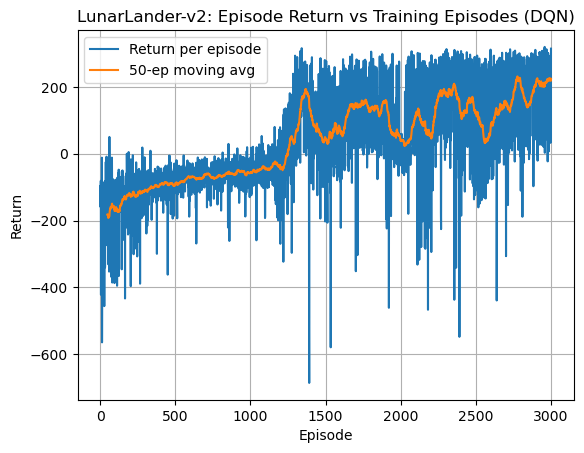

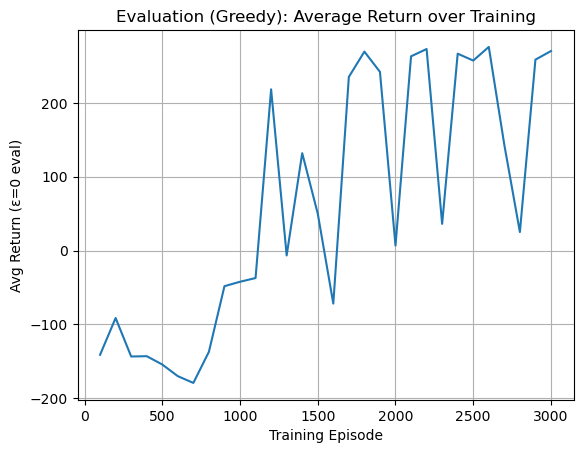

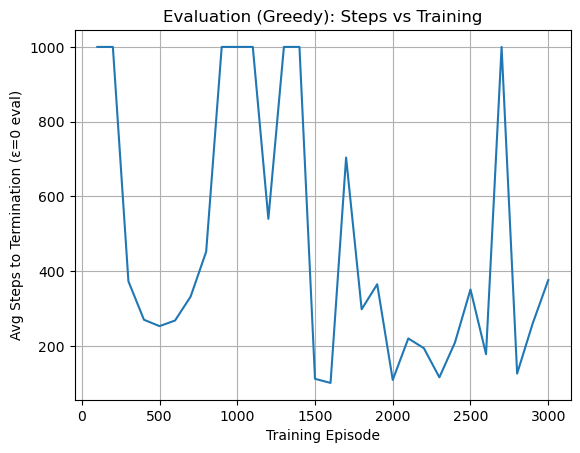

In [32]:

# ---------- Plots ----------
def plot_training_returns(returns, window=50):
    arr = np.asarray(returns, dtype=float)
    plt.figure()
    plt.plot(arr, label="Return per episode")
    if len(arr) >= window:
        mov = np.convolve(arr, np.ones(window)/window, mode="valid")
        plt.plot(range(window-1, window-1+len(mov)), mov, label=f"{window}-ep moving avg")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title("LunarLander-v2: Episode Return vs Training Episodes (DQN)")
    plt.legend(); plt.grid(True); plt.show()

plot_training_returns(rewards_per_ep)

if len(eval_ckpt) > 0:
    plt.figure()
    plt.plot(eval_ckpt, eval_avg_returns)
    plt.xlabel("Training Episode"); plt.ylabel("Avg Return (ε=0 eval)")
    plt.title("Evaluation (Greedy): Average Return over Training")
    plt.grid(True); plt.show()

    plt.figure()
    plt.plot(eval_ckpt, eval_avg_steps)
    plt.xlabel("Training Episode"); plt.ylabel("Avg Steps to Termination (ε=0 eval)")
    plt.title("Evaluation (Greedy): Steps vs Training")
    plt.grid(True); plt.show()



**Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?
    - The agent end up learning a good policy and landing consistently, as we can see in the graphs, the learning is more consistent than the mountain car problem
- How many episodes did it take before you saw improvement? 
    - It took around 1000 to cross the zero reward, and around 2500 to have good results, probably it requires more episodes, but takes a lot of of time.
- What effect did replay buffer size, target update frequency, and learning rate have on stability?
    - Bigger buffer sizes avoid overfitting, tend to be smoother and stable. Lower target-network updates can desestabilize learning but if bigger can have a slower adaptation. As is generally known, the learning rate can cause divergence if it is too low, by the other hand, bigger LRs can requiere much longer training.
- Compare results across different runs (does it sometimes fail to converge?).
    - It could vary depending on the seed, generally it converged across different runs but may be cases where different random seeds produced some variance: most runs converged to good landers.

Compare this task with the **MountainCar-v0** problem you solved earlier: Some how it took more time to train, one reason might be the double neural network. This task had 8 states compared to the previous 2 and has 4 actions instead of 3.
- What is **extra** or more challenging in LunarLander?
    - I think the large dimensionality of the states, the algorithm must deal with balancing trhust and orientation for a smooth landing.
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.
    - As already discussed, there are challenges related to the number of states and actions, but also the reward changes, so it is possible to have positive rewards. The exploration is also difficult, in MountainCar a tile algorithm might be enough, but for LunarLander is required to have a non-linear modeling to capture the system complexity.
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?
    - Mainly the 8D continuos states and the non-linear dynamics between those states. Tyle coding couldn't manage this task efficiently since this task benefits from experience replay and a target network to stabilize in the long term.

